In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

import re

In [2]:
!nvidia-smi

/bin/sh: 1: nvidia-smi: not found


## Input Pipeline

In [3]:
import csv

transcripts = []

with open('datasets/transcripts.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for i, row in enumerate(reader):
        if not i:
            continue
        transcripts.append(row[0])


In [4]:
print(len(transcripts))

2467


In [5]:
print(transcripts[:5])

['Good morning. How are you?(Laughter)It\'s been great, hasn\'t it? I\'ve been blown away by the whole thing. In fact, I\'m leaving.(Laughter)There have been three themes running through the conference which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we\'ve had and in all of the people here. Just the variety of it and the range of it. The second is that it\'s put us in a place where we have no idea what\'s going to happen, in terms of the future. No idea how this may play out.I have an interest in education. Actually, what I find is everybody has an interest in education. Don\'t you? I find this very interesting. If you\'re at a dinner party, and you say you work in education — Actually, you\'re not often at dinner parties, frankly.(Laughter)If you work in education, you\'re not asked.(Laughter)And you\'re never asked back, curiously. That\'s strange to me. But if you are, and you say to somebody, yo

In [6]:
def count_chars(char):
    c = 0
    for tran in transcripts:
         c += tran.count(char)
    return c

In [7]:
count_chars('.')

299645

In [8]:
count_chars('?')

26460

In [9]:
count_chars(',')

354791

In [10]:
count_chars('!')

2339

In [11]:
count_chars(':')

16888

In [12]:
count_chars(';')

4456

In [13]:
count_chars('-') # hyphen

25849

In [14]:
count_chars('–') # en dash

21

In [15]:
count_chars('—') # em dash

27887

In [16]:
count_chars('¿')

1

In [17]:
count_chars('"')

41385

In [18]:
count_chars('\'')

142170

In [19]:
count_chars('%')

46

In [20]:
count_chars('$')

284

In [21]:
count_chars('#')

63

In [22]:
count_chars('&')

152

In [23]:
count_chars("...")

1349

In [24]:
count_chars(" ")

5035047

#### Questions:

- What characters to keep?
- What characters to predict?
- ...

In [25]:
PUNCT = '?.,—:;'

KEPT_CHAR = "a-zA-Z0-9\-'" + PUNCT

In [26]:
import unicodedata


# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_text(w):
    w = unicode_to_ascii(w.strip())

    
    # replace ! with . (too few "!" samples)
    w = w.replace('!', '.')
    
    # removing everything in parentheses (audience reactions)
    # Reference: https://stackoverflow.com/questions/14596884/remove-text-between-and-in-python/14598135
    w = re.sub(r"[\(].*?[\)]", "", w)
    
    # setting first letter of sentences to lowercse to not give any hints as to where punctuation should be

    w = re.sub("([\"])[ ]?(\w+)", lambda x: x.group(0).lower(), w)

    w = re.sub("([?.])[ ]?(\w+)", lambda x: x.group(0).lower(), w)
    
    
    # fixing lower case "I"
    # some first sentence letters still wrongfully lowercase but difficult to fix that
    w = re.sub("( i[' ])", lambda x: x.group(0).upper(), w) 
    

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation

    w = re.sub(r"([?.,—:;])", r" \1 ", w)

    w = re.sub(r'[" "]+', " ", w)
    w = re.sub("(\d+) , (\d{3})", "\\1,\\2", w) # fixing numbers with comma

    
    # replacing everything with space except (a-z, A-Z, 0-9, ".", "?", ",", "-", "—", ":", ";")
    w = re.sub("[^" + KEPT_CHAR + "]+", " ", w)
    w = w.strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    # w = '<start> ' + w + ' <end>'
    return w

In [27]:
clean_transcripts = [preprocess_text(t) for t in transcripts]

In [28]:
print(clean_transcripts[:5])

["Good morning . how are you ? it's been great , hasn't it ? I've been blown away by the whole thing . in fact , I'm leaving . there have been three themes running through the conference which are relevant to what I want to talk about . one is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here . just the variety of it and the range of it . the second is that it's put us in a place where we have no idea what's going to happen , in terms of the future . no idea how this may play out . i have an interest in education . actually , what I find is everybody has an interest in education . don't you ? I find this very interesting . if you're at a dinner party , and you say you work in education — Actually , you're not often at dinner parties , frankly . if you work in education , you're not asked . and you're never asked back , curiously . that's strange to me . but if you are , and you say to somebody , you know , they say ,

In [29]:
print(len(clean_transcripts))

2467


In [30]:
from sklearn.model_selection import train_test_split

train_transcripts = clean_transcripts[:-int(0.2*len(clean_transcripts))]
test_transcripts = clean_transcripts[-int(0.2*len(clean_transcripts)):]


In [31]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (tr for tr in train_transcripts), target_vocab_size=2**13)

In [32]:
sample_string = 'punctuation is important.'

tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('The original string: {}'.format(original_string))

Tokenized string is [5351, 1119, 342, 12, 734, 7929]
The original string: punctuation is important.


In [33]:
for ts in tokenized_string:
    print('{} ----> {}'.format(ts, tokenizer.decode([ts])))

5351 ----> punc
1119 ----> tu
342 ----> ation 
12 ----> is 
734 ----> important
7929 ----> .


In [34]:
BUFFER_SIZE = 2000
BATCH_SIZE = 64

MAX_LENGTH = 80
print(tokenizer.vocab_size)


8139


In [35]:
def create_dataset(transcripts):
    max_words = 120
    max_len = 256
    samples_per_tran = 20
    
    dataset = []

    act_max_len_en = 0

    _lens = []
    
    for i in range(samples_per_tran):

        for tran in transcripts:
            
            if not tran:
                continue
            
            
            c = tran.count(" ")
            
            sp_tran = tran.split(" ")
            
            if c < max_words:
                print('c:', c)
                continue

            sp_i = np.random.randint(c-max_words)
            
            target = " ".join(sp_tran[sp_i:sp_i+max_words])
            
            origin = re.sub(" [" + PUNCT + "] ", " ", target)
            
            
            # encode text and add start and end token 
            enc_origin = [tokenizer.vocab_size] + tokenizer.encode(origin) + [tokenizer.vocab_size+1]
            enc_target = [tokenizer.vocab_size] + tokenizer.encode(target) + [tokenizer.vocab_size+1]
            
            if len(enc_origin)+2 > max_len or len(enc_target)+2 > max_len:
                print('encoding too long!')
                continue
            
            _lens.append(len(enc_origin))
            _lens.append(len(enc_target))

            
            
            dataset.append((enc_origin, enc_target))
    
    origin_dataset = np.zeros((len(dataset), max_len))
    target_dataset = np.zeros((len(dataset), max_len))
    
    for i in range(len(dataset)):
        origin_dataset[i][:len(dataset[i][0])] = dataset[i][0]
        target_dataset[i][:len(dataset[i][1])] = dataset[i][1]

    print(max(_lens))
    
    
    dataset = tf.data.Dataset.from_tensor_slices((origin_dataset.astype(np.int64), target_dataset.astype(np.int64))).shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset

In [37]:
train_dataset = create_dataset(train_transcripts)

c: 116
c: 117
c: 21
c: 19
c: 117
encoding too long!
c: 116
c: 117
c: 21
c: 19
c: 117
encoding too long!
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
encoding too long!
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
encoding too long!
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
encoding too long!
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
c: 116
c: 117
c: 21
c: 19
c: 117
encoding too long!
c: 116
c: 117
c: 21
c: 19
c: 117
encoding too long!
247


## Positional encoding

In [38]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model)) # (1, len(i))
    return pos * angle_rates

In [39]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
    
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


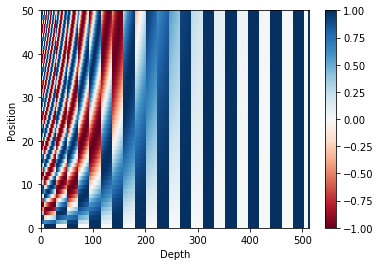

In [40]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)
a = pos_encoding.numpy()

plt.pcolormesh(pos_encoding[0], cmap='RdBu', vmin=-1, vmax=1)

plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

## Masking

In [41]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [42]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot product attention

In [43]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## Multi-head attention

In [44]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## Point wise feed forward network

In [45]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

## Encoder and decoder

### Encoder layer


In [46]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):

        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

### Decoder layer


In [47]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### Encoder

In [48]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

### Decoder

In [49]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                   maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

# Transformer

In [50]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
                    tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

## Hyperparameters

In [51]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8

input_vocab_size = tokenizer.vocab_size + 2
target_vocab_size = tokenizer.vocab_size + 2
dropout_rate = 0.1

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [53]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [54]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [55]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [56]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [57]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 20

In [ ]:

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> , tar -> 
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()))

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 5.2118 Accuracy 0.0001
